# Category classifier
The goal of this project is to output a classifier which will predict the review category.

**Customer/Use Case:** Potential customer could be Yelp to aid in tagging of businesses automatically using the input review text
    * Special care will have to be given to which prediction thresholds to use in order to strike a balance between precision & recall for the given use case.

**Approach:** 
1) Data curation and EDA (accomplished in sperate notebooks)
2) Data cleaning
    * Reducing feature and data scope (**Initially PA only**)
4) Featurize the review data
    * First pass will be using **tf-idf**, but additional embeddings could be used as time permits
5)  Budilding out classifiers
    * **Initial POC** will be binary -- restaurant, not-restaurant -- classifier.
    * Secondary will be **multi-class**
    * Plan is to test the following ML classifiers:
      * Logistic Regression
      * Random Forest
      * Gradient Boosted
      * Other classifiers as time permits
6) Evaluate classifers
   * See note above about threshold selection
7) Deployment
   * This is a stretch goal. Would be cool to host on AWS for online input

In [26]:
# Importing all packages including NLTK downloads as necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk.corpus
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve
first_run = False
if first_run:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
import dataprep

## Importing and cleaning data

In [2]:
data_import = True
if data_import:
    business = pd.read_csv("yelp_dataset/yelp_academic_dataset_business.csv", low_memory=False)
    reviews = pd.read_csv("yelp_dataset/yelp_academic_dataset_review.csv")

In [18]:
# The review cleaning function take a long time. Filtering dataset before we go further.
clean_business = dataprep.clean_business_data(business)
PA_business = clean_business[clean_business['state'] == 'PA']

filtered_reviews = reviews[reviews['business_id'].isin(PA_business['business_id'])].copy()
PA_reviews = dataprep.clean_review_data(filtered_reviews)

In [9]:
print(business.shape[0])
print(PA_business.shape[0])
print(reviews.shape[0])
print(PA_reviews.shape[0])

150346
34039
6977653
1595929


### Filtering for PA only

In [19]:
# Slicing out only the columns that we may need going forward
PA_business = PA_business[['business_id', 'name', 'category_split']]
PA_reviews = PA_reviews[['review_id', 'business_id', 'text']]

## Joining datasets

In [20]:
PA_data = PA_business.merge(PA_reviews, how='inner', on='business_id', validate='one_to_many')

### Creating target variable for binary classifier
i.e. Restaurant vs. Not-Restaurant

In [23]:
PA_data['is_restaurant'] = PA_data.apply(lambda row: row['category_split'].count('restaurants') > 0, 
                                         axis=1)

In [24]:
# The classes here are imbalanced, but there are so many records, that I'm not concerned right now
PA_data['is_restaurant'].value_counts()

is_restaurant
True     1098102
False     497827
Name: count, dtype: int64

## Getting embeddings from tf-idf for featurization

In [27]:
# Identifying stopwords from multiple sources
my_stopwords = ['review']
nltk_stop_words = list(nltk.corpus.stopwords.words('english'))
nltk_stop_words = [word.translate(str.maketrans('', '', string.punctuation)) for word in nltk_stop_words]
stopwords = list(set(list(ENGLISH_STOP_WORDS) + my_stopwords + nltk_stop_words))

In [34]:
# Lemmatizing words
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        
tf = TfidfVectorizer(strip_accents='unicode',
                     tokenizer=LemmaTokenizer(),
                     stop_words=stopwords,
                     max_features=500) # Setting at 500 for POC. Could be tuned further

In [35]:
X_train, X_test , y_train, y_test = train_test_split(PA_data['text'].values,
                                                     PA_data['is_restaurant'].values, 
                                                     test_size=0.25, 
                                                     random_state=43)

In [ ]:
# Could use n-grams here
tfidf = tf.fit_transform(X_train) #ngram_range=(1, 2)) #Including uni and bi-grams

C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [44]:
tfidf_test = tf.transform(X_test)

In [ ]:
#What classifier to use?
#Should try a few and tune them

In [57]:
#starting with logistic regresssion
#LogisticRegressionCV
lr = LogisticRegression(random_state=43, C=1000000)
lr.fit(tfidf, y_train)
y_pred = lr.predict(tfidf_test)
y_pred_score = lr.predict_proba(tfidf_test)

C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [111]:
test_text = ['best burritos in town close to my house service is excellent']
test_transform = tf.transform(test_text)
lr.predict_proba(test_transform)[0][1]

0.6036436282768367

In [112]:
test_text = ['i hate this place its the worst service ive ever experienced i will never go back']
test_transform = tf.transform(test_text)
lr.predict_proba(test_transform)[0][1]

0.6301166644835224

In [113]:
test_text = ['i love buying my car parts here']
test_transform = tf.transform(test_text)
lr.predict_proba(test_transform)[0][1]

0.026364864268046455

In [114]:
test_text = ['ive been going to this dentist for 5 years and every time ive had a good experience']
test_transform = tf.transform(test_text)
lr.predict_proba(test_transform)[0][1]

0.28928838768115

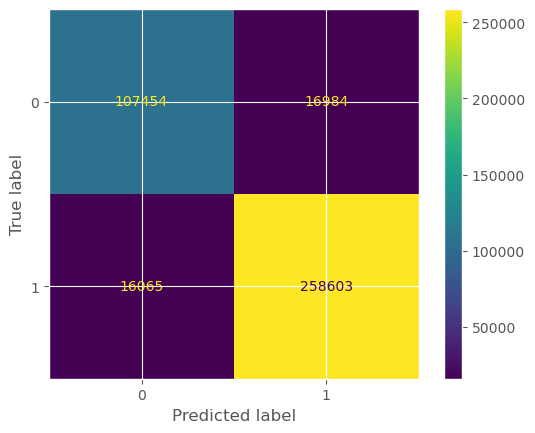

In [59]:
confusion_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix).plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


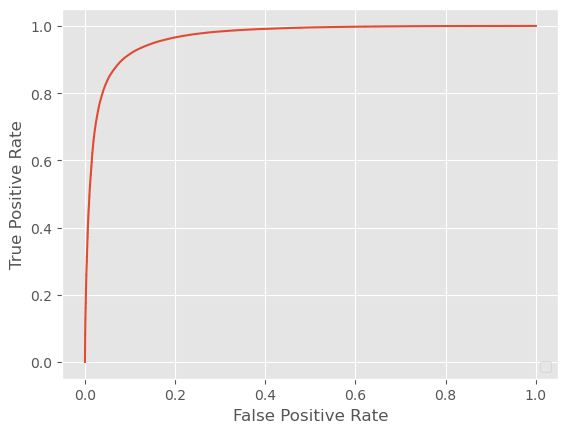

In [117]:
fpr, tpr, _ = roc_curve(y_test, y_pred_score[:,1], pos_label=lr.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

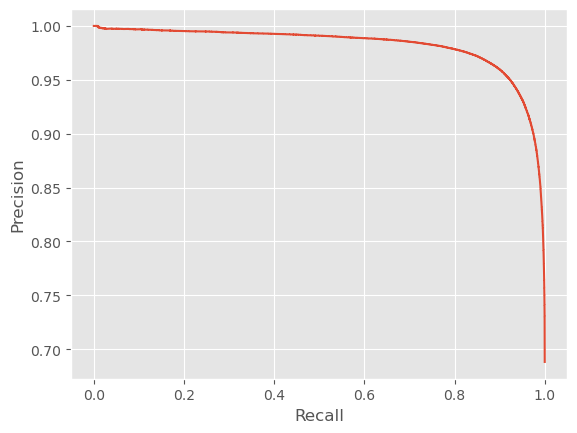

In [78]:
prec, recall, _ = precision_recall_curve(y_test, y_pred_score[:,1], pos_label=lr.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [115]:
#f1 score

In [119]:
recall

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       7.28151805e-06, 3.64075903e-06, 0.00000000e+00])

In [21]:
# filtered_reviews = reviews[reviews['business_id'].isin(filtered_data['business_id'])].copy()
# # drop duplicates
# filtered_reviews.drop_duplicates('review_id', inplace=True)
# # Removing any additional duplicate reviews from same user with same text and business
# filtered_reviews.drop_duplicates(['business_id', 'user_id', 'text'], inplace=True)
# # filtered_reviews.reset_index(drop=True, inplace=True)
# # Cleaning up text field
# filtered_reviews['text'] = filtered_reviews['text'].str.lstrip('u').str.strip().str.lower().str.translate(str.maketrans('-', ' ', string.punctuation))
# # Removing escaped characters that show up literally
# filtered_reviews['text'] = filtered_reviews['text'].str.translate(str.maketrans(dict([(chr(char), ' ') for char in range(1, 32)])))
# # Removing >1 whitespace chars
# def clean_whitespace(text):
#     return ' '.join(text.split())
# filtered_reviews['text'] = filtered_reviews.apply(lambda row: clean_whitespace(row['text']), axis=1)
# # Dropping few reviews that are NaN
# filtered_reviews = filtered_reviews[~filtered_reviews['text'].isna()]

In [2]:
# data_import = True
# if data_import:
#     business = pd.read_csv("yelp_dataset/yelp_academic_dataset_business.csv", low_memory=False)
# business.drop_duplicates('business_id', inplace=True)
# biz_columns_to_drop = ['hours', 'attributes', 'attributes.BusinessParking', 'attributes.HairSpecializesIn', 'attributes.RestaurantsAttire', 'attributes.BestNights',
#                        'attributes.Open24Hours', 'attributes.Music', 'attributes.AgesAllowed', 'attributes.BusinessAcceptsCreditCards', 'attributes.DietaryRestrictions']
# for column in biz_columns_to_drop:
#     business.drop(column, inplace=True, axis=1)
# business.reset_index(inplace=True, drop=True)
# # Likely not necessary, but updating unicode string import issue leading to leading 'u's
# unicode_fix_columns = ['attributes.Alcohol', 'attributes.Smoking', 'attributes.NoiseLevel', 'attributes.BYOBCorkage']

# for column in unicode_fix_columns:
#     business[column] = business[column].str.lstrip('u').str.strip()

# # Update names to strip punctuation and lowercase
# business['name'] = business['name'].str.strip().str.lower().str.translate(str.maketrans('', '', string.punctuation))
# # Updating corkage to fix duplicate values
# business['attributes.BYOBCorkage'] = business['attributes.BYOBCorkage'].str.split('_').str[0].value_counts()

# def split_categories(categories):
#     try:
#         output = categories.split(',')
#         return [x.strip().lower() for x in output]
#     except:
#         return ""
        
# business['category_split'] = business.apply(lambda row: split_categories(row['categories']), axis=1)

# categories_to_check = ['restaurants']
# business['applicable_categories'] = business['category_split'].apply(lambda x : 1 if any(i in x for i in categories_to_check) else 0)